In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import xarray as xr
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from netCDF4 import Dataset
from datetime import datetime, timedelta, date
import matplotlib.dates as mdates
import matplotlib.patheffects as PathEffects
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.io import shapereader

import geopandas
import regionmask
from matplotlib.path import Path

ERROR 1: PROJ: proj_create_from_database: Open of /home/bwallace/.conda/envs/geo_env/share/proj failed


## Define cartopy projection

In [2]:
# Set some projections for our data (Plate Carree)
# and output maps (Lambert Conformal)

# Data projection;
dataproj = ccrs.PlateCarree()

# Plot projection
# The look you want for the view, LambertConformal for mid-latitude view
plotproj = ccrs.LambertConformal(central_longitude=-100.,
                                 central_latitude=40.,
                                 standard_parallels=[30, 60])

## Pull in coordinate info & get shapefile for defining regions

In [3]:
wrf_native_coords=xr.open_dataset('data/wrf_coords.nc')
wrf_lat=wrf_native_coords.lat
wrf_lon=wrf_native_coords.lon

CESM_coords=xr.open_dataset('data/cesm_coords.nc')
CESM_lat=CESM_coords.lat
CESM_lon=CESM_coords.lon
CESM_lon,CESM_lat=np.meshgrid(CESM_lon,CESM_lat)

# request data for use by geopandas
resolution = '110m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)
df=df[df.TYPE=='Country']
USA=df[df.SOV_A3=='US1']

shpfilename_lakes = shapereader.natural_earth('110m', 'physical', 'lakes')
lakes_df = geopandas.read_file(shpfilename_lakes)

lakes_df=lakes_df[lakes_df.name_alt=='Great Lakes']#.geometry

glakes_mask=regionmask.mask_geopandas(lakes_df.geometry,wrf_lon,wrf_lat)
glakes_mask_cesm=regionmask.mask_geopandas(lakes_df.geometry,CESM_lon,CESM_lat)

usa_mask=regionmask.mask_geopandas(USA.geometry,wrf_lon,wrf_lat)
usa_mask_cesm=regionmask.mask_geopandas(USA.geometry,CESM_lon,CESM_lat)

## Define subregions

In [4]:
xy_points=np.vstack((wrf_lon.values.flatten(),wrf_lat.values.flatten())).T
xy_points_cesm=np.vstack((CESM_lon.flatten(),CESM_lat.flatten())).T

vert_dict={}
vert_dict['sw']=[(-94.5,38),(-130,38),(-130,20),(-94.5,20)]
vert_dict['se']=[(-94.5,38),(-20,38),(-20,20),(-94.5,20)]
vert_dict['ne']=[(-81,38),(-20,38),(-20,50),(-81,50)]
vert_dict['mw']=[(-81,38),(-104,38),(-104,50),(-81,50)]
vert_dict['nr']=[(-104,38),(-121,38),(-121,50),(-104,50)]
vert_dict['nw']=[(-121,38),(-131,38),(-131,50),(-121,50)]

mask_dict={}
for key in vert_dict.keys():
    p=Path(vert_dict[key])
    grid=p.contains_points(xy_points)
    mask_dict[key]=grid.reshape(wrf_lat.shape)
    mask_dict[key]=xr.DataArray(mask_dict[key]).where(~np.isnan(usa_mask.values)).where(np.isnan(glakes_mask.values))
    mask_dict[key]=mask_dict[key].rename({'dim_0':'south_north','dim_1':'west_east'})

vert_dict={}
vert_dict['sw']=[(-94.5+360,38),(-130+360,38),(-130+360,20),(-94.5+360,20)]
vert_dict['se']=[(-94.5+360,38),(-20+360,38),(-20+360,20),(-94.5+360,20)]
vert_dict['ne']=[(-81+360,38),(-20+360,38),(-20+360,50),(-81+360,50)]
vert_dict['mw']=[(-81+360,38),(-104+360,38),(-104+360,50),(-81+360,50)]
vert_dict['nr']=[(-104+360,38),(-121+360,38),(-121+360,50),(-104+360,50)]
vert_dict['nw']=[(-121+360,38),(-131+360,38),(-131+360,50),(-121+360,50)]

mask_cesm_dict={}
for key in vert_dict.keys():
    p=Path(vert_dict[key])
    grid=p.contains_points(xy_points_cesm)
    mask_cesm_dict[key]=grid.reshape(CESM_lat.shape)
    mask_cesm_dict[key]=xr.DataArray(mask_cesm_dict[key]).where(~np.isnan(usa_mask_cesm.values)).where(np.isnan(glakes_mask_cesm.values))
    mask_cesm_dict[key]=mask_cesm_dict[key].rename({'dim_0':'lat','dim_1':'lon'})

## Call in the data

In [5]:
datasets={}
cesm_datasets={}
regrid_datasets={}

for season in ['DJF','JJA','ALL']:
    datasets[season]={}
    path='data/wrf_native_total_rain_'+season+'.nc'
    datasets[season]['hist']=xr.open_mfdataset(path).AFWA_TOTPRECIP
    path='data/wrf_native_total_rain_eoc8p5_'+season+'.nc'
    datasets[season]['eoc8p5']=xr.open_dataset(path).AFWA_TOTPRECIP

    datasets[season]['diff']=datasets[season]['eoc8p5']-datasets[season]['hist']
    datasets[season]['pdiff']=datasets[season]['diff']/datasets[season]['hist']

for season in ['DJF','JJA','ALL']:
    regrid_datasets[season]={}
    path='data/WRF_REGRID_total_rain_'+season+'.nc'
    regrid_datasets[season]['hist']=xr.open_mfdataset(path).AFWA_TOTPRECIP
    regrid_datasets[season]['hist']=regrid_datasets[season]['hist'].sel(lat=slice(CESM_lat.min(),CESM_lat.max()),lon=slice(CESM_lon.min(),CESM_lon.max()))
    path='data/WRF_REGRID_total_rain_eoc8p5_'+season+'.nc'
    regrid_datasets[season]['eoc8p5']=xr.open_dataset(path).AFWA_TOTPRECIP
    regrid_datasets[season]['eoc8p5']=regrid_datasets[season]['eoc8p5'].sel(lat=slice(CESM_lat.min(),CESM_lat.max()),lon=slice(CESM_lon.min(),CESM_lon.max()))

    regrid_datasets[season]['diff']=regrid_datasets[season]['eoc8p5']-regrid_datasets[season]['hist']
    regrid_datasets[season]['pdiff']=regrid_datasets[season]['diff']/regrid_datasets[season]['hist']
    
for season in ['DJF','JJA','ALL']:
    cesm_datasets[season]={}
    path='data/CESM_total_rain_'+season+'.nc'
    cesm_datasets[season]['hist']=xr.open_mfdataset(path).__xarray_dataarray_variable__
    cesm_datasets[season]['hist']=cesm_datasets[season]['hist'].sel(lat=slice(CESM_lat.min(),CESM_lat.max()),lon=slice(CESM_lon.min(),CESM_lon.max()))
    path='data/CESM_total_rain_eoc8p5_'+season+'.nc'
    cesm_datasets[season]['eoc8p5']=xr.open_dataset(path).__xarray_dataarray_variable__
    cesm_datasets[season]['eoc8p5']=cesm_datasets[season]['eoc8p5'].sel(lat=slice(CESM_lat.min(),CESM_lat.max()),lon=slice(CESM_lon.min(),CESM_lon.max()))

    cesm_datasets[season]['diff']=cesm_datasets[season]['eoc8p5']-cesm_datasets[season]['hist']
    cesm_datasets[season]['pdiff']=cesm_datasets[season]['diff']/cesm_datasets[season]['hist']

In [6]:
letters=['a. ','b. ','c. ','d. ','e. ','f. ','g. ','h. ','i. ','j. ','k. ','l. ','m. ','n. ','o. ','p. ']

season_arranged=['ALL','DJF','JJA']
dset_arranged=['WRF ','WRF-REGRID ','CESM ']

## Plot the data

/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/bwallace/.conda/envs/geo_env/li

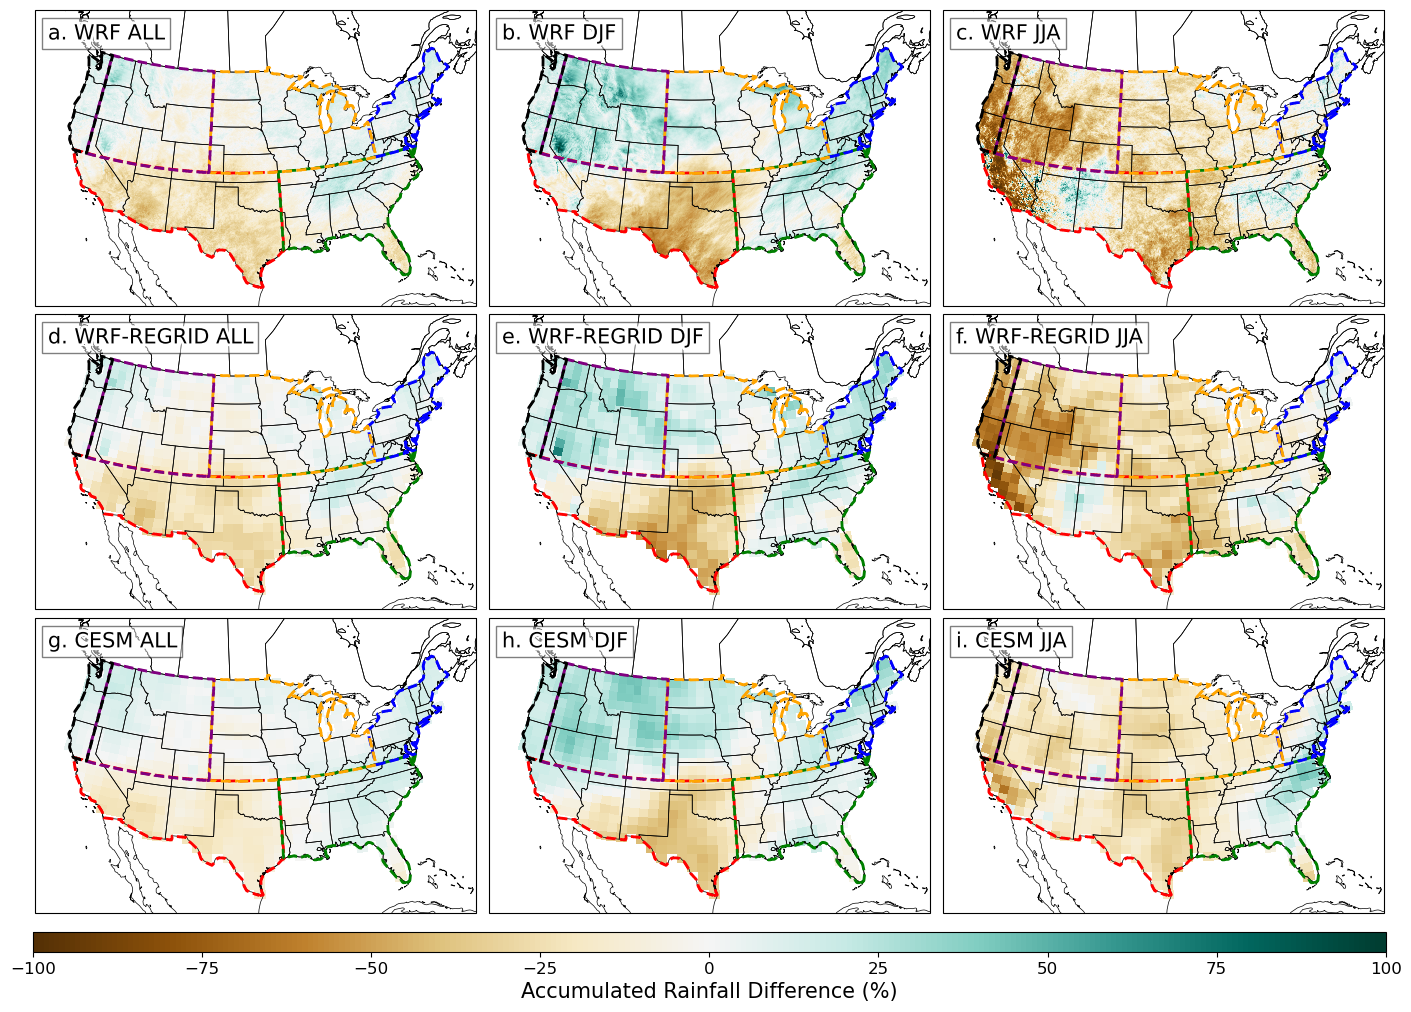

In [7]:
fig=plt.figure(constrained_layout=True, figsize=(14,10))
gs=fig.add_gridspec(3,3)

axs=[]
for i in range(9):
    axs.append(fig.add_subplot(gs[i],projection=plotproj))

    axs[-1].set_extent([-123., -73, 24., 53.],ccrs.PlateCarree())
    axs[-1].add_feature(cfeature.COASTLINE, linewidth=0.5)
    axs[-1].add_feature(cfeature.STATES, linewidth=0.5)

    axs[-1].contour(wrf_lon,wrf_lat,xr.DataArray(mask_dict['sw']).fillna(0),
               np.arange(-1,1,1),colors='red',linewidths=2,
               linestyles='--',transform=dataproj)
    axs[-1].contour(wrf_lon,wrf_lat,xr.DataArray(mask_dict['se']).fillna(0),
               np.arange(-1,1,1),colors='green',linewidths=2,
               linestyles='--',transform=dataproj)
    axs[-1].contour(wrf_lon,wrf_lat,xr.DataArray(mask_dict['ne']).fillna(0),
               np.arange(-1,1,1),colors='blue',linewidths=2,
               linestyles='--',transform=dataproj)
    axs[-1].contour(wrf_lon,wrf_lat,xr.DataArray(mask_dict['mw']).fillna(0),
               np.arange(-1,1,1),colors='orange',linewidths=2,
               linestyles='--',transform=dataproj)
    axs[-1].contour(wrf_lon,wrf_lat,xr.DataArray(mask_dict['nr']).fillna(0),
               np.arange(-1,1,1),colors='purple',linewidths=2,
               linestyles='--',transform=dataproj)
    axs[-1].contour(wrf_lon,wrf_lat,xr.DataArray(mask_dict['nw']).fillna(0),
               np.arange(-1,1,1),colors='black',linewidths=2,
               linestyles='--',transform=dataproj)
    t=axs[-1].text(0.03,0.9,letters[i]+dset_arranged[i//3]+season_arranged[i%3],size=15,color='k',\
              horizontalalignment='left',\
              path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],\
              transform=axs[i].transAxes)
    t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))
    
for i in range(9):
    if i//3==0:
        c=axs[i].pcolormesh(wrf_lon,wrf_lat,
                     100*datasets[season_arranged[i%3]]['pdiff'].\
                      where(~np.isnan(usa_mask)).where(np.isnan(glakes_mask)),
                     cmap='BrBG',vmin=-100,vmax=100,
                     transform=dataproj)

    elif i//3==1:
        c=axs[i].pcolormesh(CESM_coords.lon,CESM_coords.lat,
                     100*regrid_datasets[season_arranged[i%3]]['pdiff'].\
                      where(~np.isnan(usa_mask_cesm.values)).where(np.isnan(glakes_mask_cesm.values)),
                     cmap='BrBG',vmin=-100,vmax=100,
                     transform=dataproj)

    elif i//3==2:
        c=axs[i].pcolormesh(CESM_coords.lon,CESM_coords.lat,
                     100*cesm_datasets[season_arranged[i%3]]['pdiff'].\
                      where(~np.isnan(usa_mask_cesm.values)).where(np.isnan(glakes_mask_cesm.values)),
                     cmap='BrBG',vmin=-100,vmax=100,
                     transform=dataproj)

    if i==0:
        cbar_axs=[]
    cbar_axs.append(axs[i])
    if i==8:
        cbar=plt.colorbar(c,ax=cbar_axs,orientation='horizontal',aspect=70,fraction=0.04,pad=0.02)
        cbar.set_label('Accumulated Rainfall Difference (%)',fontsize=15)
        cbar.ax.tick_params(labelsize=12)

plt.show()
plt.close()